<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/CYRE3SA/CYRE3SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from keras.metrics import mean_squared_error

In [2]:
url = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/'+
       'TemporalSeries/CYRE3SA/CYRE3SA.csv')

In [3]:
url_data = requests.get(url).content
raw_data = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [4]:
raw_data = raw_data[["Date","Close"]]
raw_data.index = pd.to_datetime(raw_data["Date"])
raw_data.drop("Date", axis = 1, inplace =  True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
raw_data = raw_data['2008-01-01':]

In [6]:
raw_data.isna().sum()

Close    0
dtype: int64

In [7]:
data = raw_data

In [8]:
data

,Close
Date,
2008-01-02,23.709999
2008-01-03,23.490000
2008-01-04,23.000000
2008-01-07,23.000000
2008-01-08,24.350000
...,...
2022-03-22,16.549999
2022-03-23,17.030001
2022-03-24,17.620001


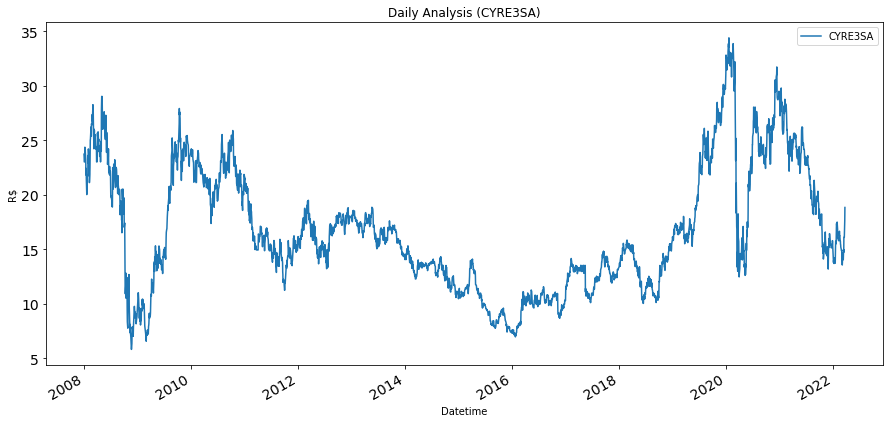

In [9]:
data.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'CYRE3SA')
plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')

## **SPLITTING DATA:**

In [10]:
split1 = int(0.7*len(data))
split2 = int(0.9*len(data))
train = data[:split1]
test = data[split1:split2]
actual_forecast = data[split2:]

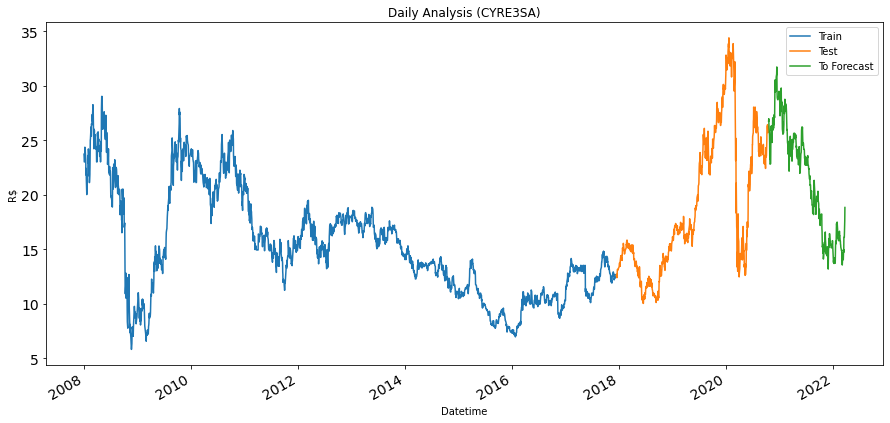

In [14]:
train.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Train')
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Test')
actual_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'To Forecast')
plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')

## **PREPARING TRAINING DATA:**

In [15]:
input_train = train.values
input_train = input_train.reshape((-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
input_train = scaler.fit_transform(input_train)

In [16]:
LOOK_BACK = 100
X_train = []
y_train = []

In [17]:
for i in range (LOOK_BACK, len(input_train)):
  X_train.append(input_train[i-LOOK_BACK:i,0])
  y_train.append(input_train[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], LOOK_BACK, 1))

## **TRAINING LSTM:**

In [18]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True,
                   input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50))
model.add(Dropout(0.3))


model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'rmsprop', loss = 'mse',
                  metrics = ['mse'])

model.fit(X_train, y_train, epochs = 100, batch_size = 32, workers=-1)

Epoch 1/100
75/75 [==============================] - 22s 194ms/step - loss: 0.0188 - mse: 0.0188
Epoch 2/100
75/75 [==============================] - 15s 195ms/step - loss: 0.0094 - mse: 0.0094
Epoch 3/100
75/75 [==============================] - 14s 190ms/step - loss: 0.0078 - mse: 0.0078
Epoch 4/100
75/75 [==============================] - 14s 189ms/step - loss: 0.0066 - mse: 0.0066
Epoch 5/100
75/75 [==============================] - 15s 202ms/step - loss: 0.0058 - mse: 0.0058
Epoch 6/100
75/75 [==============================] - 14s 187ms/step - loss: 0.0053 - mse: 0.0053
Epoch 7/100
75/75 [==============================] - 14s 190ms/step - loss: 0.0047 - mse: 0.0047
Epoch 8/100
75/75 [==============================] - 15s 196ms/step - loss: 0.0042 - mse: 0.0042
Epoch 9/100
75/75 [==============================] - 14s 188ms/step - loss: 0.0039 - mse: 0.0039
Epoch 10/100
75/75 [==============================] - 14s 187ms/step - loss: 0.0037 - mse: 0.0037
Epoch 11/100
75/75 [=========

## **LSTM in the Train Dataset:**

In [19]:
yhat_train = model.predict(X_train)
yhat_train = scaler.inverse_transform(yhat_train)
yhat_train = pd.DataFrame(yhat_train, columns = ['Close'])

In [20]:
yhat_train["Date"] = train[LOOK_BACK:].index
yhat_train.index = pd.to_datetime(yhat_train["Date"])
yhat_train.drop("Date", axis = 1, inplace =  True)

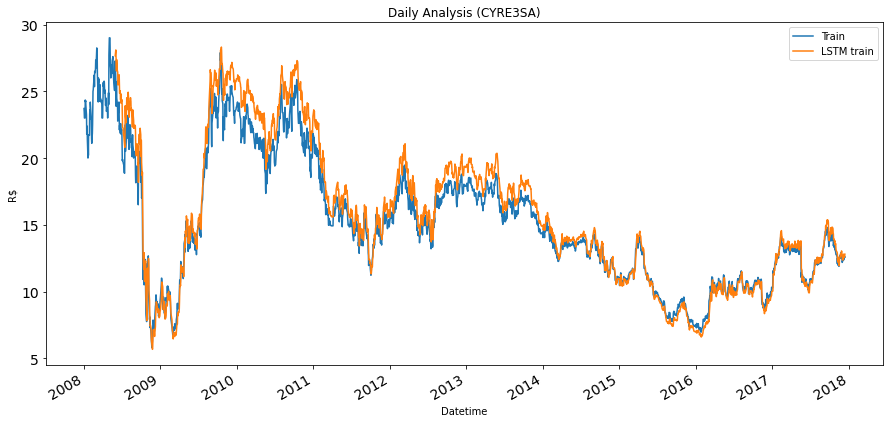

In [21]:
train.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Train')
yhat_train.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM train')

plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')

In [22]:
train_mse = np.reshape(train.values, (train.values.shape[0]))
yhat_train_mse = np.reshape(yhat_train.values, (yhat_train.values.shape[0]))
MSE_train = mean_squared_error(train_mse[LOOK_BACK:], yhat_train_mse)
MSE_train

<tf.Tensor: shape=(), dtype=float32, numpy=1.4508113>

# **LSTM in the Test Dataset:**

In [23]:
complete_data = data[:split2].values
input_test = complete_data[len(complete_data) - len(test) - LOOK_BACK:]
input_test = input_test.reshape((-1, 1))
input_test = scaler.transform(input_test)

In [24]:
X_test = []
for i in range(LOOK_BACK, len(input_test)):
  X_test.append(input_test[i-LOOK_BACK:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [25]:
yhat_test = model.predict(X_test)
yhat_test = scaler.inverse_transform(yhat_test)

In [26]:
yhat_test = pd.DataFrame(yhat_test, columns = ['Close'])
yhat_test["Date"] = test.index
yhat_test.index = pd.to_datetime(yhat_test["Date"])
yhat_test.drop("Date", axis = 1, inplace =  True)

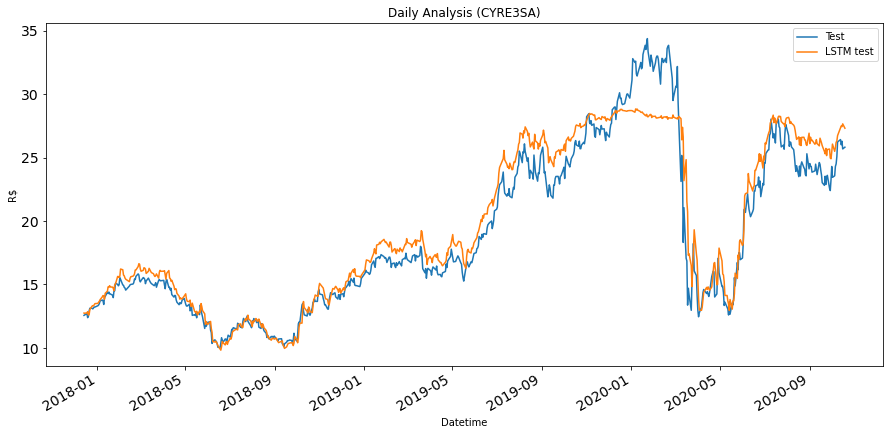

In [27]:
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Test')
yhat_test.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM test')

plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')

In [28]:
test_mse = np.reshape(test.values, (test.values.shape[0]))
yhat_test_mse = np.reshape(yhat_test.values, (yhat_test.values.shape[0]))
MSE_test = mean_squared_error(test_mse, yhat_test_mse)
MSE_test

<tf.Tensor: shape=(), dtype=float32, numpy=2.9230797>

In [38]:
df_interval = pd.DataFrame()
df_interval['actual'] = test.Close.values
df_interval['predicts'] = yhat_test.values
df_interval['error'] = df_interval.actual-df_interval.predicts

errors description: count    706.000000
mean      -0.627108
std        1.591667
min       -8.311242
25%       -1.448124
50%       -0.750503
75%       -0.126210
max        6.149227
Name: error, dtype: float64


Text(0.5, 1.0, 'Error')

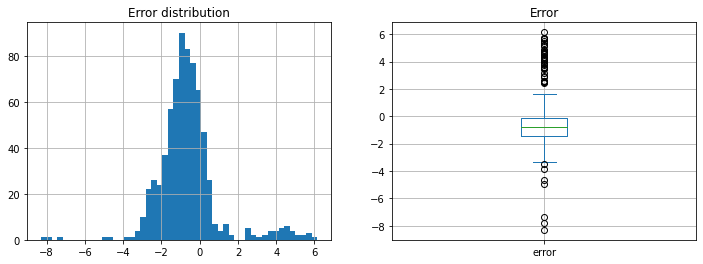

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
print("errors description:", df_interval.error.describe())
df_interval.error.hist(bins=50).set_title('Error distribution')
plt.subplot(122)
df_interval.error.plot(kind='box', grid=True).set_title("Error")

In [40]:
err_std = df_interval.error.std(axis=0)
err_mean = df_interval.error.mean(axis=0)

## **Forecasting:**

In [29]:
FORECAST_DAYS = len(actual_forecast+30)
forecasted_lst = []

In [30]:
input_forecast = test[len(test) - LOOK_BACK :].values
input_forecast = scaler.fit_transform(input_forecast)
input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [31]:
for i in range(FORECAST_DAYS):
  forecast = model.predict(input_forecast)
  forecasted_lst.append(forecast)
  input_forecast = np.reshape(input_forecast, (input_forecast.shape[1], 1))
  input_forecast = np.concatenate((input_forecast,forecast))
  input_forecast = input_forecast[-LOOK_BACK:]
  input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [32]:
forecasted_lst = np.array(forecasted_lst)
forecasted_lst = forecasted_lst.reshape((-1, 1))
forecasted_lst = scaler.inverse_transform(forecasted_lst)

In [33]:
last_test_date = test.index[-1]
initial_forecast_date = pd.date_range(last_test_date, periods = 2, freq='D' )
initial_forecast_date = initial_forecast_date[-1]
initial_forecast_date

Timestamp('2020-10-20 00:00:00', freq='D')

In [34]:
forecast_dates = pd.date_range(initial_forecast_date, periods = 
                                      FORECAST_DAYS, freq='D')

In [35]:
LSTM_forecast = pd.DataFrame(forecasted_lst, columns = ['Close'])
LSTM_forecast["Date"] = forecast_dates
LSTM_forecast.index = LSTM_forecast["Date"]
LSTM_forecast.drop("Date", axis = 1, inplace =  True)

In [36]:
yhat_forecast = pd.DataFrame(forecasted_lst, columns = ['Close'])
yhat_forecast["Date"] = forecast_dates
yhat_forecast.index = yhat_forecast["Date"]
yhat_forecast.drop("Date", axis = 1, inplace =  True)

In [46]:
pred_upper = yhat_forecast.Close + 1.96*err_std
pred_lower = yhat_forecast.Close - 1.96*err_std
err_x = yhat_forecast.Close.index[:]

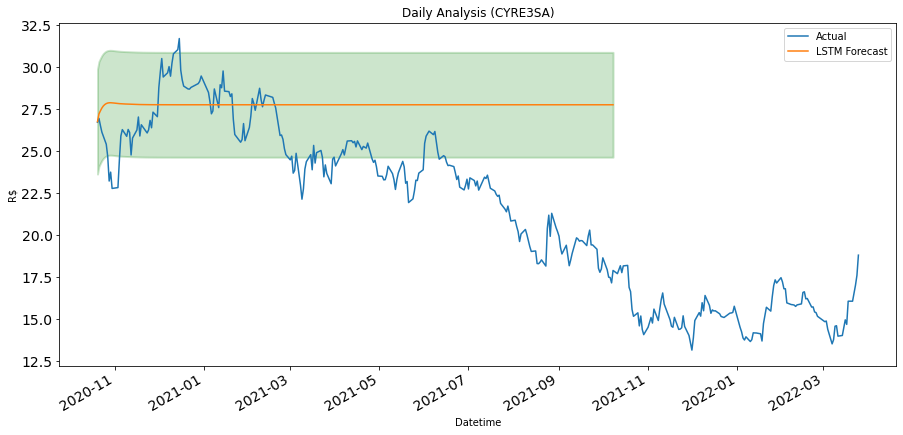

In [47]:
actual_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Actual')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
yhat_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM Forecast')

plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')

In [66]:
len(actual_forecast), len(yhat_forecast)

(354, 354)

## **Final:**

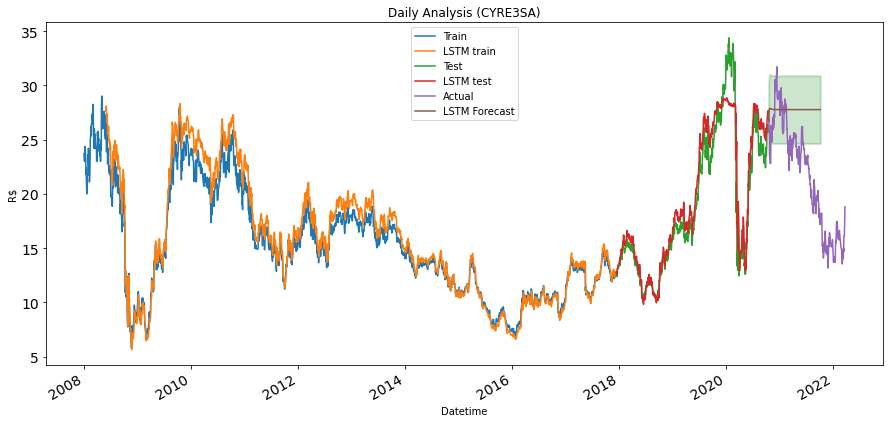

In [48]:
train.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Train')
yhat_train.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM train')
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Test')
yhat_test.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM test')

actual_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'Actual')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
yhat_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (CYRE3SA)', 
                 fontsize =14, label = 'LSTM Forecast')


plt.xlabel('Datetime')
plt.ylabel('R$')
plt.legend(loc = 'best')